In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Image

import os, sys, re, datetime, time, copy
from pathlib import Path

pj_dir = Path(os.getcwd()).parents[1]
data_dir = pj_dir/'Documents/jupyter/slack/data'
img_dir = pj_dir/'Documents/jupyter/slack/images'
src_dir = pj_dir/'Documents/jupyter/slack/src'
sys.path.append(str(src_dir))

from matplotlib import pyplot as plt
import jpholiday
from tqdm import tqdm_notebook
from dotenv import load_dotenv

import seaborn as sns
plt.style.use("bmh")
import numpy as np
import pandas as pd
import dask.dataframe as dd
import requests

import MeCab
from sklearn.manifold import TSNE
from wordcloud import WordCloud

from gensim import models
from gensim.models.doc2vec import TaggedDocument

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (16, 4)
plt.rcParams["font.family"] = "AppleGothic"
import logging
logging.basicConfig(level=logging.INFO)

In [6]:
pd.set_option("display.max_rows", 100)
load_dotenv(pj_dir/'.env')

True

# Slackデータの取得

In [7]:
token = os.environ.get('SLACK_TOKEN')
#token = "SLACK_TOKEN"
print(token)

None


In [6]:
headers = {
    "Content-type": "application/json",
    "Authorization": f"Bearer {token}"
}

In [8]:
def fetch_messages_by_channel(channe_id):
    oldest_ts = None
    one_year_ago = pd.to_datetime('2018-12-31')
    endpoint = 'https://slack.com/api/channels.history'

    ls_messages = []
    while True:
        payload = {
            'channel': channel_id,
            'latest': oldest_ts,
            'count': 1000,
            'token': token
        }

        data = requests.get(endpoint, headers=headers, params=payload).json()
        messages = data['messages']
        ls_messages.extend(messages)

        if data['has_more']:
            time.sleep(1)
            oldest_ts = messages[-1]['ts']
            oldest_datetime = pd.to_datetime(oldest_ts, unit='s')
            sys.stdout.write(f"\r{oldest_datetime}")
            sys.stdout.flush()
            if oldest_datetime < one_year_ago:
                sys.stdout.write(f"\rfinish!" + ' '*50)
                break
        else:
            break
    df = pd.DataFrame(ls_messages)
    df['channel_id'] = channel_id
    return df

In [9]:
ls_df = []
ls_err_channel_id = []
endpoint = 'https://slack.com/api/channels.list'
payload = {'token': token}
data = requests.get(endpoint, headers=headers, params=payload).json()
df_channel = pd.DataFrame(data['channels'])
for i, row in tqdm_notebook(df_channel.iterrows()):
    channel_id = row['id']
    try:
        df = fetch_messages_by_channel(channel_id)
    except:
        print(f"Error on {row['name']}")
        ls_err_channel_id.append(channel_id)
    else:
        ls_df.append(df)
    time.sleep(1)

NameError: name 'headers' is not defined

In [10]:
df = pd.concat(ls_df)

ValueError: No objects to concatenate

In [120]:
endpoint = 'https://slack.com/api/channels.list'
payload = {'token': token}

data = requests.get(endpoint, headers=headers, params=payload).json()
df_channel = pd.DataFrame(data['channels'])

In [121]:
endpoint = 'https://slack.com/api/users.list'
payload = {'token': token}

data = requests.get(endpoint, headers=headers, params=payload).json()
df_member = pd.DataFrame(data['members'])

# 保存

In [14]:
df.to_pickle(data_dir/'kaizen_slack/all_messages.pickle')
df_channel.to_pickle(data_dir/'kaizen_slack/channels.pickle')
df_member.to_pickle(data_dir/'kaizen_slack/members.pickle')
df.to_pickle(data_dir/'kaizen_slack/messages.pickle')

# ロード

In [15]:
dfall = pd.read_pickle(data_dir/'kaizen_slack/all_messages.pickle')
df_channel = pd.read_pickle(data_dir/'kaizen_slack/channels.pickle')
df_member = pd.read_pickle(data_dir/'kaizen_slack/members.pickle')
df = pd.read_pickle(data_dir/'kaizen_slack/messages.pickle')

# mapping作成

In [16]:
user_id_name_map = df_member.set_index('id')['name'].to_dict()

In [17]:
channel_name_id_map = df_channel.set_index('id')['name'].to_dict()

# 前処理

In [18]:
# datetimeに変換
df['dt'] = pd.to_datetime(df['ts'], unit='s')

# 1年前からの発言に絞る
one_year_ago = pd.to_datetime('2017-12-31')
df = df.query('@one_year_ago < dt')

# usernameをmap
df['username'] = df['user'].map(user_id_name_map)

# channel nameをmap
df['channel_name'] = df['channel_id'].map(channel_name_id_map)

# botを削除
df = df[df['bot_id'].isnull()]
df = df.query('username != "cronbot"').query('username != "slackbot"')

# メッセージだけに絞る

In [19]:
not_message_types = ['channel_join', 'channel_leave', 'channel_topic', 'channel_archive', 'channel_purpose', 'sh_room_created', 'channel_name', 'pinned_item', 'reminder_add', 'app_conversation_join']
df = df[~df['subtype'].isin(not_message_types)]

# @されてるユーザー

In [20]:
df['at_user'] = df['text'].str.extract(r'(?<=<@)(.{1,9})(?=>)')
df['at_username'] = df['at_user'].map(user_id_name_map)

# 発言数

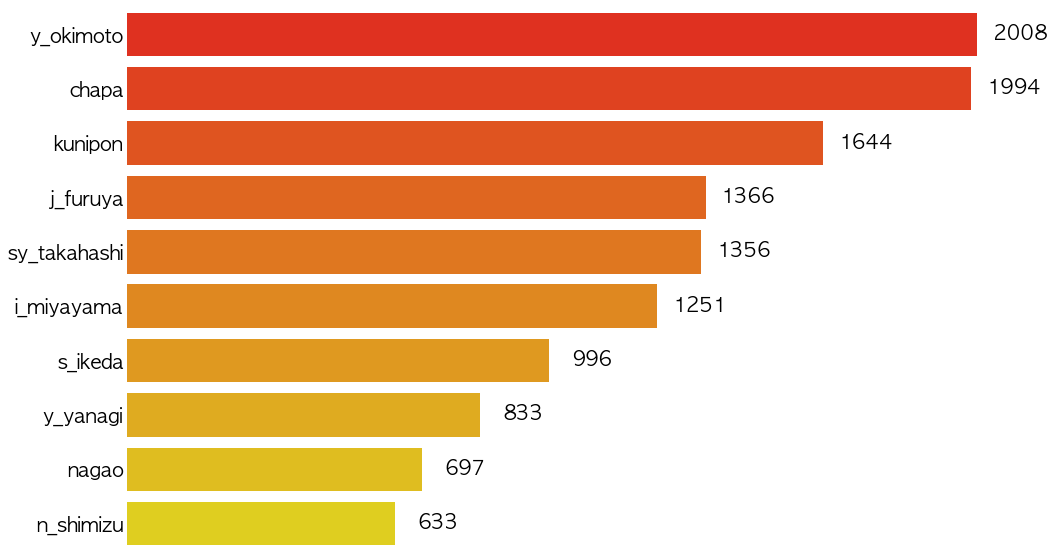

In [113]:
s = df['username'].value_counts()[:10]
#print(df['username'].value_counts())

n = s.shape[0]
fig = plt.figure(figsize=(16,1*n))

tmp_df = s.to_frame('value').reset_index().rename(columns={'index': 'name'})
ax = sns.barplot(x='value', y='name', palette="autumn", data=tmp_df)
max_ = tmp_df['value'].max()

for i, (_, row) in enumerate(tmp_df.iterrows()):
    text = ax.text(row['value'] + max_*.05, i+0.1, row['value'], color='black', ha="center", fontsize=20)

[spine.set_visible(False) for spine in ax.spines.values()]
ax.tick_params(bottom=False, left=False, labelbottom=False)
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_title('2018年 発言した人 TOP10', fontsize=30)
ax.patch.set_facecolor('white') 

ax.patch.set_alpha(0)
plt.grid(False)

# @された数

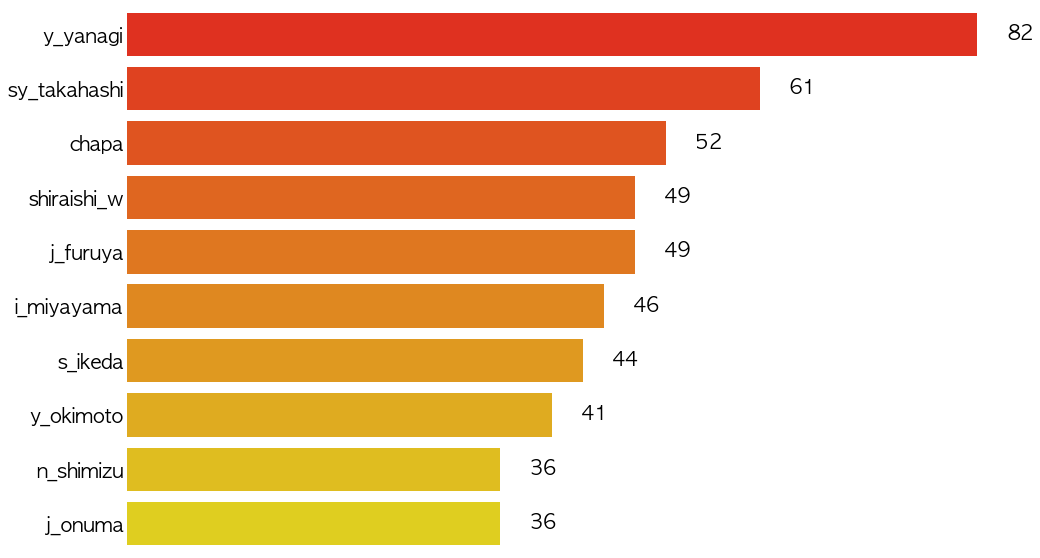

In [106]:
s = df['at_username'].value_counts()[:10]

n = s.shape[0]
fig = plt.figure(figsize=(16,1*n))

tmp_df = s.to_frame('value').reset_index().rename(columns={'index': 'name'})
ax = sns.barplot(x='value', y='name', data=tmp_df, palette="autumn")
max_ = tmp_df['value'].max()

for i, (_, row) in enumerate(tmp_df.iterrows()):
    text = ax.text(row['value'] + max_*.05, i+0.1, row['value'], color='black', ha="center", fontsize=20)

[spine.set_visible(False) for spine in ax.spines.values()]
ax.tick_params(bottom=False, left=False, labelbottom=False)
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_title('2018年 @された数 TOP10', fontsize=30)
ax.patch.set_facecolor('white') 

ax.patch.set_alpha(0)
plt.grid(False)

# 一番使われたリアクションは？

In [30]:
from collections import defaultdict

In [31]:
count_reaction = defaultdict(int)
for reactions in tqdm_notebook(df['reactions'].fillna('')):
    if len(reactions) == 0:
        continue
    for reaction in reactions:
        name = reaction['name']
        count = len(reaction['users'])
        count_reaction[name] += count

iine                                  189
nanyate                               116
+1                                    927
azamasu                              1176
clap                                  415
www                                     9
+1::skin-tone-2                        10
sasuga                                309
juhn                                   44
cry                                    25
so-good                                 8
fb-wow                                 91
aws                                    35
tada                                  188
trollface                               7
sorena                                348
man-bowing                            485
daijini                               761
mask                                   24
ganba                                  72
onashasu                              121
zap                                     2
naru                                  145
tashikani                         

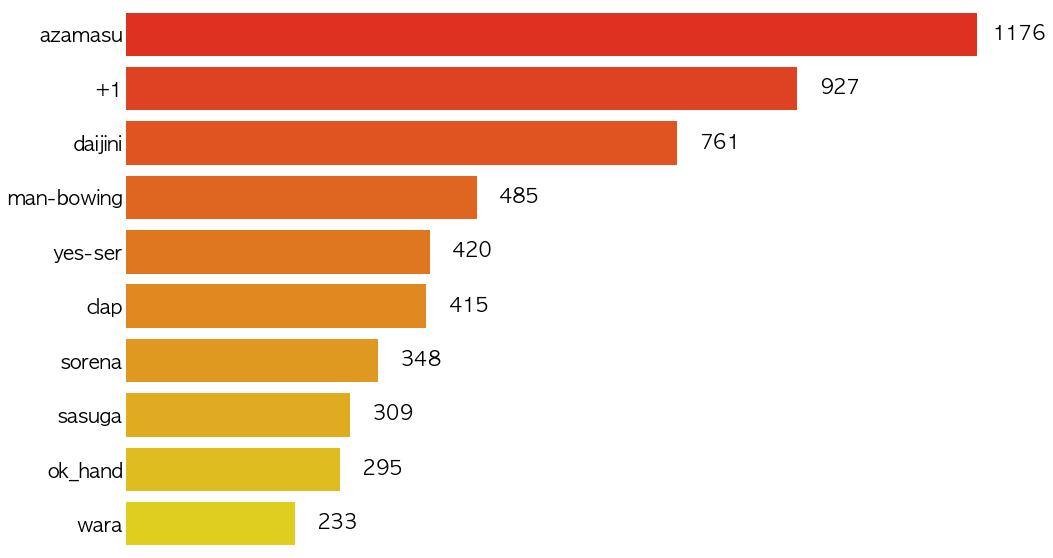

In [116]:
s = pd.Series(count_reaction).sort_values(ascending=False)[:10]
print(pd.Series(count_reaction))
n = s.shape[0]
fig = plt.figure(figsize=(16,1*n))

tmp_df = s.to_frame('value').reset_index().rename(columns={'index': 'name'})
ax = sns.barplot(x='value', y='name', data=tmp_df, palette="autumn")
max_ = tmp_df['value'].max()

for i, (_, row) in enumerate(tmp_df.iterrows()):
    text = ax.text(row['value'] + max_*.05, i+0.1, row['value'], color='black', ha="center", fontsize=20)

[spine.set_visible(False) for spine in ax.spines.values()]
ax.tick_params(bottom=False, left=False, labelbottom=False)
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_title('2018年 使われたリアクション TOP10', fontsize=30)
ax.patch.set_facecolor('white') 

ax.patch.set_alpha(0)
plt.grid(False)

# 時系列で見た発言数

In [33]:
is_weekday_date =[dt for dt in pd.date_range('2018-1-1', '2018-12-27', freq='1D') if dt.weekday() in [0, 1, 2, 3, 4] and not jpholiday.is_holiday(dt.date())]

Text(0, 0.5, '')

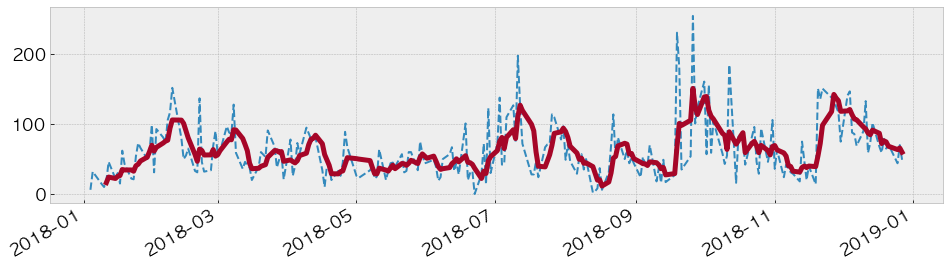

In [92]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)
ax = df.groupby(pd.Grouper(key='dt', freq='1D')).size()[is_weekday_date].plot(linewidth=2, linestyle='--', ax=ax)
ax = df.groupby(pd.Grouper(key='dt', freq='1D')).size()[is_weekday_date].rolling(window=5).mean().plot(linewidth=5, ax=ax)
#ax.set_title('1日あたりの発言数(休日祝日は除く) ※破線が実数、実線が周期5の移動平均', fontsize=20)
ax.tick_params(axis='both', labelsize='xx-large')
ax.set_xlabel('')
ax.set_ylabel('')

# Channel数

In [35]:
df_channel['created_dt'] = pd.to_datetime(df_channel['created'], unit='s')

In [38]:
s_added = df_channel.groupby(pd.Grouper(key='created_dt', freq='1W')).size()
s_archived = dfall.query('subtype == "channel_archive"').groupby(pd.Grouper(key='datetime', freq='1W')).size()

                                          attachments bot_id bot_link  \
0                                                 NaN    NaN      NaN   
1                                                 NaN    NaN      NaN   
2                                                 NaN    NaN      NaN   
3                                                 NaN    NaN      NaN   
4                                                 NaN    NaN      NaN   
5                                                 NaN    NaN      NaN   
6                                                 NaN    NaN      NaN   
7                                                 NaN    NaN      NaN   
8                                                 NaN    NaN      NaN   
0                                                 NaN    NaN      NaN   
1                                                 NaN    NaN      NaN   
2                                                 NaN    NaN      NaN   
3                                                 N

KeyError: 'The grouper name datetime is not found'

# transactionデータ作成

In [78]:
df_transition_channel = pd.concat([s_added, s_archived], axis=1).rename(columns={0: 'added', 1: 'archived'})
df_transition_channel.fillna(0, inplace=True)
df_transition_channel['count_channel'] = (df_transition_channel['added'] - df_transition_channel['archived']).cumsum()

NameError: name 's_archived' is not defined

In [77]:
df_transition_channel[one_year_ago < df_transition_channel.index]['added'].sum(), df_transition_channel[one_year_ago < df_transition_channel.index]['archived'].sum()

NameError: name 'df_transition_channel' is not defined

NameError: name 'df_transition_channel' is not defined

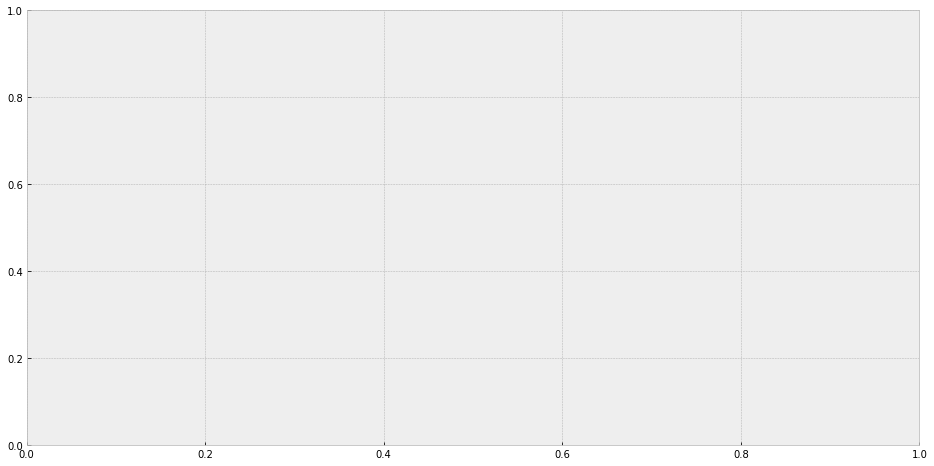

In [76]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
s = df_transition_channel['count_channel']
ax = s.plot(linewidth=5, linestyle='-', ax=ax, label='総Channel数')
ax.set_title('左軸: Channel数   右軸: 作成/アーカイブ数', fontsize=20)
ax.tick_params(axis='both', labelsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
plt.legend(fontsize=20, loc='lower right')

ax2 = ax.twinx()
s = df_transition_channel['added'].rolling(window=7).mean()
s.plot(linewidth=3, linestyle='--', ax=ax2, label='作成数/day', color='C1')
s = df_transition_channel['archived'].rolling(window=7).mean()
s.plot(linewidth=3, linestyle='--', ax=ax2, label='アーカイブ数/day', color='C3')
ax2.tick_params(axis='both', labelsize=15)
plt.legend(fontsize=20)

# 時系列細かく

In [67]:
weekday_str_map = {
    0: '月', 1: '火', 2: '水', 3: '木', 4: '金', 5: '土', 6: '日'
}

In [68]:
df_daily = df.groupby(pd.Grouper(key='dt', freq='1D')).size()[is_weekday_date].to_frame('count')

In [69]:
df_daily['weekday'] = df_daily.index.weekday.map(weekday_str_map)
df_daily['day_in_month'] = df_daily.index.day

Text(0, 0.5, '')

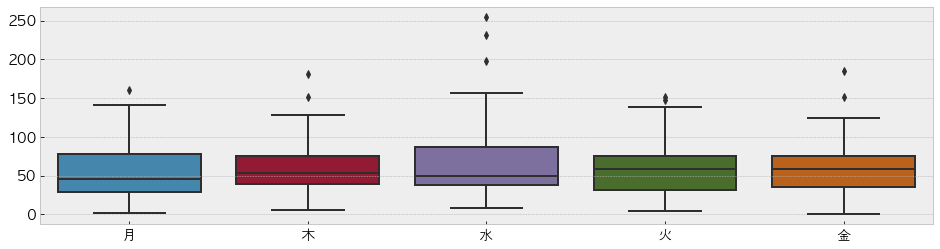

In [93]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)
ax = sns.boxplot(data=df_daily.sort_values('weekday'), x='weekday', y='count')
#ax.set_title('曜日による発言数の分布', fontsize=20)
ax.tick_params(axis='both', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')

Text(0, 0.5, '')

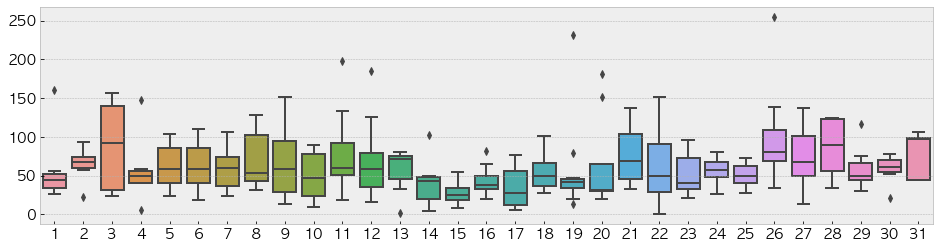

In [94]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)
ax = sns.boxplot(data=df_daily.sort_values('day_in_month'), x='day_in_month', y='count')
#ax.set_title('日付による発言数の分布', fontsize=20)
ax.tick_params(axis='both', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')

In [72]:
is_weekday = df['dt'].dt.weekday.isin([0, 1, 2, 3, 4]) & ~df['dt'].dt.date.apply(jpholiday.is_holiday)

Text(0, 0.5, '')

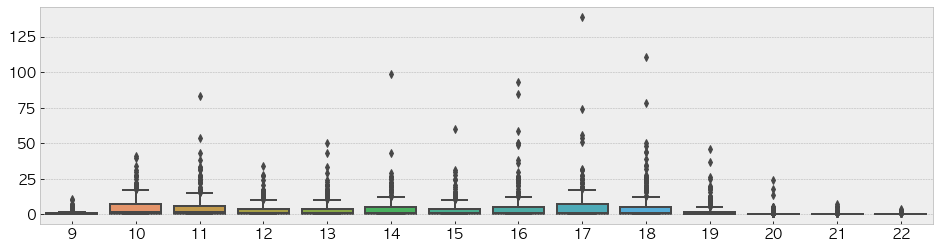

In [101]:
df_hourly = df[is_weekday].groupby(pd.Grouper(key='dt', freq='1h')).size().to_frame('count')
df_hourly['hour'] = df_hourly.index.hour +9
work_hours = list(range(9, 23))

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)
ax = sns.boxplot(data=df_hourly.query('hour in @work_hours').sort_values('hour'), x='hour', y='count')
#ax.set_title('時間帯による発言数の分布', fontsize=20)
ax.tick_params(axis='both', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')

channel_name
aws_room                  140
blockchain                 24
bot_bitbucket              61
bot_bitbucket_casval        1
bot_bitbucket_insight      16
bot_face_recruit           87
bot_innobell                6
bot_innobell_stg            1
bot_issay_proto_test3     773
bot_jenkins_innobell       18
bot_jira                    7
bot_stockprice              3
bot_trello                 23
bot_trello_casval-dev       3
bot_trello_nomippa          2
bot_trello_travel-ios       1
bouldering                 19
data_tgif                  56
dataanalytics             202
debug_slack_notifier        5
dev_spring                 23
device_talk                 6
diet_show                 976
feed_pivotal_security       2
furuya_sketch               8
general                   445
ggr_ng                     37
help_furuya                34
hokats_engineer           127
hunnnnnnnpon               35
incident_fuervo_local       8
incident_innobell          21
issay_room                1

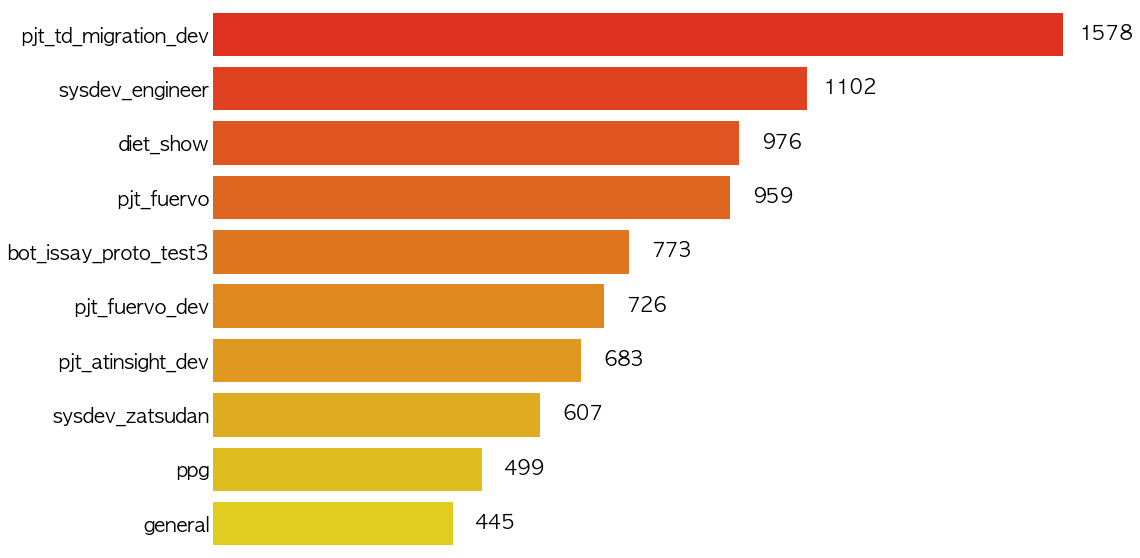

In [111]:
s = df.groupby('channel_name').size().sort_values(ascending=False)[:10]

n = s.shape[0]
fig = plt.figure(figsize=(16,1*n))

tmp_df = s.to_frame('value').reset_index().rename(columns={'channel_name': 'name'})
ax = sns.barplot(x='value', y='name', data=tmp_df, palette="autumn")
max_ = tmp_df['value'].max()

for i, (_, row) in enumerate(tmp_df.iterrows()):
    text = ax.text(row['value'] + max_*.05, i+0.1, row['value'], color='black', ha="center", fontsize=20)

[spine.set_visible(False) for spine in ax.spines.values()]
ax.tick_params(bottom=False, left=False, labelbottom=False)
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_title('2018年 発言が多かったChannel TOP5', fontsize=30)
ax.patch.set_facecolor('white') 

ax.patch.set_alpha(0)
plt.grid(False)

Text(0, 0.5, '')

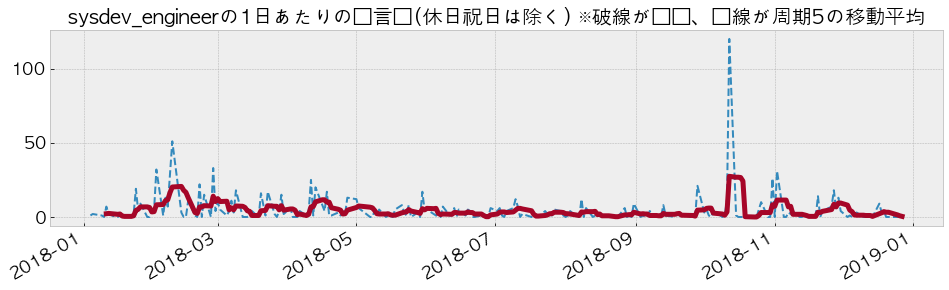

In [77]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)
ax = df.query('channel_name == "sysdev_engineer"').groupby(pd.Grouper(key='dt', freq='1D')).size()[is_weekday_date].plot(linewidth=2, linestyle='--', ax=ax)
ax = df.query('channel_name == "sysdev_engineer"').groupby(pd.Grouper(key='dt', freq='1D')).size()[is_weekday_date].rolling(window=5).mean().plot(linewidth=5, ax=ax)
ax.set_title('sysdev_engineerの1日あたりの発言数(休日祝日は除く) ※破線が実数、実線が周期5の移動平均', fontsize=20)
ax.tick_params(axis='both', labelsize='xx-large')
ax.set_xlabel('')
ax.set_ylabel('')

Text(0, 0.5, '')

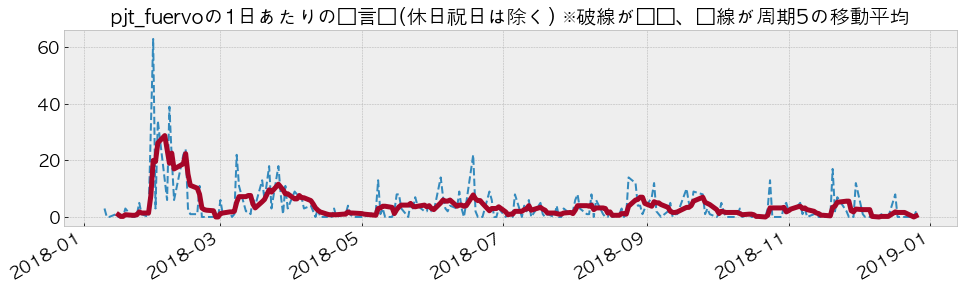

In [78]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)
ax = df.query('channel_name == "pjt_fuervo"').groupby(pd.Grouper(key='dt', freq='1D')).size()[is_weekday_date].plot(linewidth=2, linestyle='--', ax=ax)
ax = df.query('channel_name == "pjt_fuervo"').groupby(pd.Grouper(key='dt', freq='1D')).size()[is_weekday_date].rolling(window=5).mean().plot(linewidth=5, ax=ax)
ax.set_title('pjt_fuervoの1日あたりの発言数(休日祝日は除く) ※破線が実数、実線が周期5の移動平均', fontsize=20)
ax.tick_params(axis='both', labelsize='xx-large')
ax.set_xlabel('')
ax.set_ylabel('')

In [79]:
# s = df[df['channel_name'].str.contains('times_')].groupby('channel_name').size().sort_values(ascending=False)[:5]

# n = s.shape[0]
# fig = plt.figure(figsize=(16,1*n))

# tmp_df = s.to_frame('value').reset_index().rename(columns={'channel_name': 'name'})
# ax = sns.barplot(x='value', y='name', data=tmp_df, palette="autumn")
# max_ = tmp_df['value'].max()

# for i, (_, row) in enumerate(tmp_df.iterrows()):
#     text = ax.text(row['value'] + max_*.05, i+0.1, row['value'], color='black', ha="center", fontsize=20)

# [spine.set_visible(False) for spine in ax.spines.values()]
# ax.tick_params(bottom=False, left=False, labelbottom=False)
# ax.tick_params(axis='y', labelsize=20)
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.set_title('2018年 発言が多かったtimes TOP5', fontsize=30)
# ax.patch.set_facecolor('white') 

# ax.patch.set_alpha(0)
# plt.grid(False)

In [80]:
def plot_hist(s, title, bins=30, xlabel='', ylabel=''):
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 1, 1)

    mean =s.mean().round(2)
    median = s.median().round(2)
    std = s.std().round(2)

    sns.distplot(s, ax=ax, bins=bins, kde_kws={"color": "k", "lw": 3})
    ax.set_title(title, fontsize=20)
    ax.tick_params(axis = 'x', which = 'major', labelsize = 20)
    vals = ax.get_yticks()
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    ax.text( 0.99, 0.99, f"平均値: {mean:.2f} \n 中央値: {median:.2f} \n 標準偏差: {std:.2f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=20)

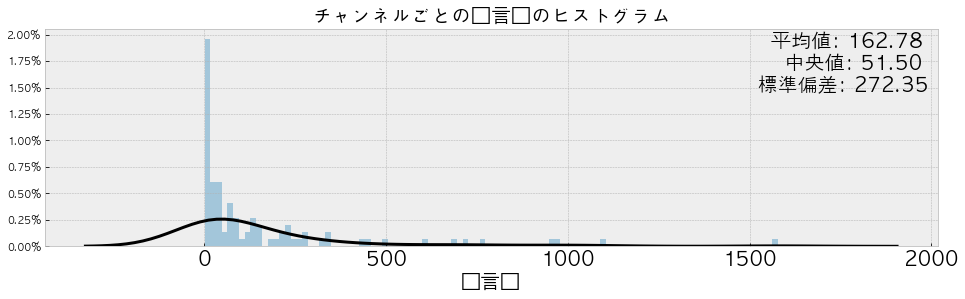

In [81]:
s = df.groupby('channel_name').size().sort_values(ascending=False)
s = s[s > 0]
plot_hist(s, 'チャンネルごとの発言数のヒストグラム', bins=100, xlabel='発言数')

Text(0.5, 1.0, 'Slcak Channelと発言数のパレート図')

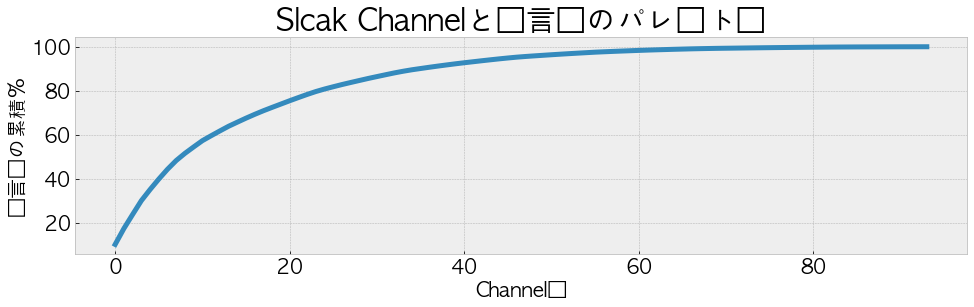

In [82]:
s = df.groupby('channel_name').size().sort_values(ascending=False)
sum_ = s.sum()
tmp_df = pd.concat([s, s.cumsum(), 100*s.cumsum()/sum_], axis=1)
tmp_df.columns = ['number', 'cumsum', 'cumsum_percent']

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)

n = tmp_df.shape[0]
x = np.arange(0, n)
ax.plot(x, tmp_df['cumsum_percent'], linewidth=5)
ax.tick_params(axis='both', labelsize=20)
ax.set_xlabel('Channel数', fontsize=20)
ax.set_ylabel('発言数の累積％', fontsize=20)
ax.set_title('Slcak Channelと発言数のパレート図', fontsize=30)

# 自然言語処理

In [41]:
df['text_trimed'] = df['text'].str.replace(r'<\S+>', '').str.replace(r':\S+:', '').str.replace('\n', '')

# Doc2Vec

In [42]:
tmp_df = df.groupby('channel_name').size().sort_values(ascending=False)
top100_channel = tmp_df[:100].index.tolist()
top10_channel = tmp_df[:10].index.tolist()
top20_channel = tmp_df[:20].index.tolist()

In [51]:
grouped = df.query('channel_name in @top100_channel').groupby('channel_name')
channel_words = {}
for channel_name, tmp_df in tqdm_notebook(grouped):
    doc = ''.join(tmp_df['text_trimed'].values.tolist())
    channel_words[channel_name] = split_into_words(doc)

In [49]:
def split_into_words(doc):
    mecab = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")
    lines = mecab.parse(doc).splitlines()
    words = []
    for line in tqdm_notebook(lines):
        chunks = line.split('\t')
        if len(chunks) > 3 and (chunks[3].startswith('動詞') or chunks[3].startswith('形容詞') or (chunks[3].startswith('名詞') and not chunks[3].startswith('名詞-数'))):
            words.append(chunks[0])
    return words

In [50]:
stop_words = [ 'てる', 'いる', 'なる', 'れる', 'する', 'ある', 'こと', 'これ', 'さん', 'して', \
         'くれる', 'やる', 'くださる', 'そう', 'せる', 'した',  '思う',  \
         'それ', 'ここ', 'ちゃん', 'くん', '', 'て','に','を','は','の', 'が', 'と', 'た', 'し', 'で', \
         'ない', 'も', 'な', 'い', 'か', 'ので', 'よう', '', '思い', 'なっ', 'でき', 'いい', 'もの', 'あり', 'なり', 'ところ',
        'こちら', '本日', 'おり', 'ください', 'お願い', 'いたし', 'ため', 'いただき', 'gt', 'commented', 'on', '思っ', '行っ', 
        'しまっ', 'やっ', '行き', 'とき', 'できる', '自分', '書い', 'あと'
    ]

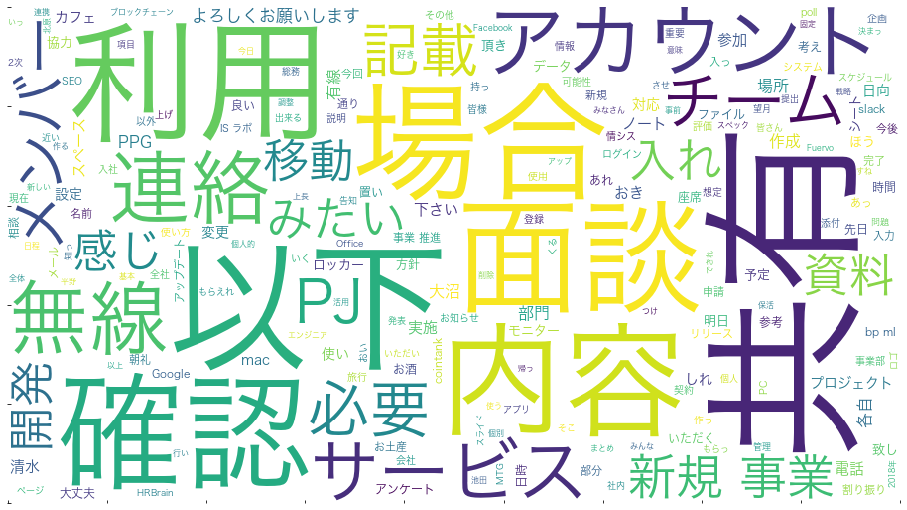

In [117]:
channel_name = 'general'

tmp_df = df.query(f'channel_name == "{channel_name}"')    
tmp_doc = ''.join(tmp_df['text_trimed'].values.tolist())
tmp_words = split_into_words(tmp_doc)

fig = plt.figure(figsize=(16, 10))
fpath = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"

wordcloud = WordCloud(background_color="white", width=900, height=500, font_path=fpath, stopwords=stop_words).generate(" ".join(tmp_words))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(wordcloud)
[spine.set_visible(False) for spine in ax.spines.values()]

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.grid(False)
#ax.set_title(f'#{channel_name}', fontsize=20)

Text(0.5, 1.0, '#random')

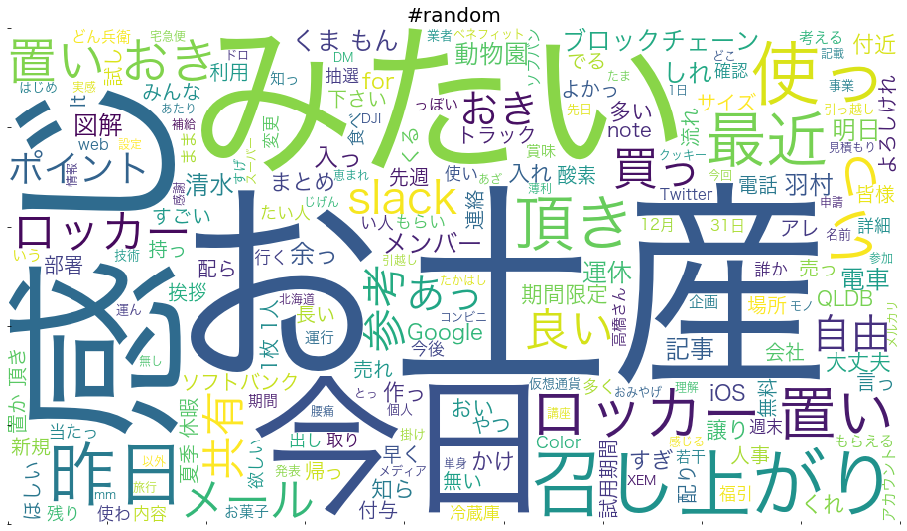

In [53]:
channel_name = 'random'

tmp_df = df.query(f'channel_name == "{channel_name}"')    
tmp_doc = ''.join(tmp_df['text_trimed'].values.tolist())
tmp_words = split_into_words(tmp_doc)

fig = plt.figure(figsize=(16, 10))
fpath = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"

wordcloud = WordCloud(background_color="white", width=900, height=500, font_path=fpath, stopwords=stop_words).generate(" ".join(tmp_words))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(wordcloud)
[spine.set_visible(False) for spine in ax.spines.values()]

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.grid(False)
ax.set_title(f'#{channel_name}', fontsize=20)

In [54]:
channel_name = 'times_ikedayu'

tmp_df = df.query(f'channel_name == "{channel_name}"')    
tmp_doc = ''.join(tmp_df['text_trimed'].values.tolist())
tmp_words = split_into_words(tmp_doc)

fig = plt.figure(figsize=(16, 10))
fpath = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"

wordcloud = WordCloud(background_color="white", width=900, height=500, font_path=fpath, stopwords=stop_words).generate(" ".join(tmp_words))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(wordcloud)
[spine.set_visible(False) for spine in ax.spines.values()]

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.grid(False)
ax.set_title(f'#{channel_name}', fontsize=20)

ValueError: We need at least 1 word to plot a word cloud, got 0.

<Figure size 1152x720 with 0 Axes>

# Doc2Vec

In [83]:
sentences = []
for channel_name, words in channel_words.items():
    td = TaggedDocument(words=words, tags=[channel_name])
    sentences.append(td)

In [84]:
model = models.Doc2Vec(sentences, dm=0, vector_size=300, window=15, alpha=.025, min_alpha=.025, min_count=1, sample=1e-6)

print('\n訓練開始')
for epoch in range(20):
    print('Epoch: {}'.format(epoch + 1))
    model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)
    model.alpha -= (0.025 - 0.0001) / 19
    model.min_alpha = model.alpha

INFO:gensim.models.doc2vec:collecting all words and their counts
INFO:gensim.models.doc2vec:PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO:gensim.models.doc2vec:collected 16369 word types and 94 unique tags from a corpus of 94 examples and 144577 words
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=1 retains 16369 unique words (100% of original 16369, drops 0)
INFO:gensim.models.word2vec:effective_min_count=1 leaves 144577 word corpus (100% of original 144577, drops 0)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 16369 items
INFO:gensim.models.word2vec:sample=1e-06 downsamples 16369 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 14923 word corpus (10.3% of prior 144577)
INFO:gensim.models.base_any2vec:estimated required memory for 16369 words and 300 dimensions: 47601700 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.base_a


訓練開始
Epoch: 1


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (14977 effective words) took 0.1s, 293187 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 144577 raw words (15057 effective words) took 0.1s, 241479 effective words/s
INFO:gensim.models.base_any2vec:training on a 722885 raw words (75058 effective words) took 0.3s, 224221 effective words/s
INFO:gensim.models.base_any2vec:training model with 3 workers on 16369 

Epoch: 2


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 144577 raw words (14894 effective words) took 0.1s, 219827 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (15066 effective words) took 0.1s, 228336 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.mo

Epoch: 3


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 144577 raw words (15012 effective words) took 0.1s, 259947 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (14939 effective words) took 0.1s, 242995 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 144577 raw words (14936 effective words) took 0.

Epoch: 4


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (15089 effective words) took 0.1s, 215694 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 144577 raw words (15119 effective words) took 0.1s, 187336 effective words/s
INFO:gensim.models.base_any2vec:training on a 722885 raw words (75249 effective words) took 0.3s, 221528 effective words/s
INFO:gensim.models.base_any2vec:training model with 3 workers on 16369 

Epoch: 5


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 144577 raw words (15114 effective words) took 0.1s, 215510 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (15183 effective words) took 0.1s, 253649 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.mo

Epoch: 6


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (15150 effective words) took 0.1s, 250558 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 144577 raw words (14955 effective words) took 0.1s, 235495 effective words/s
INFO:gensim.models.base_any2vec:training on a 722885 raw words (75117 effective words) took 0.3s, 235216 effective words/s
INFO:gensim.models.base_any2vec:training model with 3 workers on 16369 

Epoch: 7


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 144577 raw words (15047 effective words) took 0.1s, 251664 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (14980 effective words) took 0.1s, 243649 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.mo

Epoch: 8


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (15121 effective words) took 0.1s, 262533 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 144577 raw words (15107 effective words) took 0.1s, 244476 effective words/s
INFO:gensim.models.base_any2vec:training on a 722885 raw words (74981 effective words) took 0.3s, 238397 effective words/s
INFO:gensim.models.base_any2vec:training model with 3 workers on 16369 

Epoch: 9


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 144577 raw words (15033 effective words) took 0.1s, 242187 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (14815 effective words) took 0.1s, 230997 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 144577 raw words (15088 effective words) took 0.

Epoch: 10


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (15101 effective words) took 0.1s, 248287 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 144577 raw words (14997 effective words) took 0.1s, 231750 effective words/s
INFO:gensim.models.base_any2vec:training on a 722885 raw words (75127 effective words) took 0.3s, 238948 effective words/s
INFO:gensim.models.base_any2vec:training model with 3 workers on 16369 

Epoch: 11


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 144577 raw words (14990 effective words) took 0.1s, 251679 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (14955 effective words) took 0.1s, 254036 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.mo

Epoch: 12


INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 144577 raw words (15141 effective words) took 0.1s, 252112 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (15064 effective words) took 0.1s, 249171 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 144577 raw words (15197 effective words) took 0.1s, 189160 effective words/s
INFO:gensim.models.base_any2vec:training on a 722885 raw word

Epoch: 13


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (15218 effective words) took 0.1s, 266537 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 144577 raw words (14948 effective words) took 0.1s, 248060 effective words/s
INFO:gensim.models.base_any2vec:training on a 722885 raw words (75469 effective words) took 0.3s, 233318 effective words/s
INFO:gensim.models.base_any2vec:training model with 3 workers on 16369 

Epoch: 14


INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 144577 raw words (15017 effective words) took 0.1s, 238387 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (15227 effective words) took 0.1s, 257210 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 144577 raw words (14974 effective words) took 0.1s, 217503 effective words/s
INFO:gensim.models.base_any2vec:training on a 722885 raw word

Epoch: 15


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (15094 effective words) took 0.1s, 267497 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 144577 raw words (15001 effective words) took 0.1s, 212243 effective words/s
INFO:gensim.models.base_any2vec:training on a 722885 raw words (75345 effective words) took 0.3s, 225920 effective words/s
INFO:gensim.models.base_any2vec:training model with 3 workers on 16369 

Epoch: 16


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (15180 effective words) took 0.1s, 282078 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 144577 raw words (15111 effective words) took 0.1s, 230686 effective words/s
INFO:gensim.models.base_any2vec:training on a 722885 raw words (75309 effective words) took 0.3s, 231980 effective words/s
INFO:gensim.models.base_any2vec:training model with 3 workers on 16369 

Epoch: 17


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (15011 effective words) took 0.1s, 252423 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 144577 raw words (15136 effective words) took 0.1s, 231420 effective words/s
INFO:gensim.models.base_any2vec:training on a 722885 raw words (75251 effective words) took 0.3s, 225186 effective words/s
INFO:gensim.models.base_any2vec:training model with 3 workers on 16369 

Epoch: 18


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (15041 effective words) took 0.1s, 259387 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 144577 raw words (15133 effective words) took 0.1s, 235152 effective words/s
INFO:gensim.models.base_any2vec:training on a 722885 raw words (75034 effective words) took 0.3s, 238649 effective words/s
INFO:gensim.models.base_any2vec:training model with 3 workers on 16369 

Epoch: 19


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (14979 effective words) took 0.1s, 221735 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 144577 raw words (15092 effective words) took 0.1s, 247849 effective words/s
INFO:gensim.models.base_any2vec:training on a 722885 raw words (75312 effective words) took 0.3s, 224376 effective words/s
INFO:gensim.models.base_any2vec:training model with 3 workers on 16369 

Epoch: 20


INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 144577 raw words (14937 effective words) took 0.1s, 228491 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 144577 raw words (14965 effective words) took 0.1s, 228589 effective words/s
INFO:gensim.models.base_any2vec:training on a 722885 raw words (75169 effective words) took 0.3s, 225853 effective words/s


In [85]:
model.save(str(data_dir/'kaizen_slack/d2v.model'))

INFO:gensim.utils:saving Doc2Vec object under /Users/n_shimizu/Documents/jupyter/slack/data/kaizen_slack/d2v.model, separately None
INFO:gensim.utils:saved /Users/n_shimizu/Documents/jupyter/slack/data/kaizen_slack/d2v.model


In [86]:
model = models.Doc2Vec.load(str(data_dir/'kaizen_slack/d2v.model'))

INFO:gensim.utils:loading Doc2Vec object from /Users/n_shimizu/Documents/jupyter/slack/data/kaizen_slack/d2v.model
INFO:gensim.utils:loading vocabulary recursively from /Users/n_shimizu/Documents/jupyter/slack/data/kaizen_slack/d2v.model.vocabulary.* with mmap=None
INFO:gensim.utils:loading trainables recursively from /Users/n_shimizu/Documents/jupyter/slack/data/kaizen_slack/d2v.model.trainables.* with mmap=None
INFO:gensim.utils:loading wv recursively from /Users/n_shimizu/Documents/jupyter/slack/data/kaizen_slack/d2v.model.wv.* with mmap=None
INFO:gensim.utils:loading docvecs recursively from /Users/n_shimizu/Documents/jupyter/slack/data/kaizen_slack/d2v.model.docvecs.* with mmap=None
INFO:gensim.utils:loaded /Users/n_shimizu/Documents/jupyter/slack/data/kaizen_slack/d2v.model


In [87]:
ls_similar_doc = []
for channel_name in top20_channel:
    similar_doc = {'channel_name': channel_name}
    similar_channels = model.docvecs.most_similar(channel_name, topn=3)
    for i, (cname, value) in enumerate(similar_channels):
        text = f"{cname}({value:.2f})"
        similar_doc[f'{i+1}位'] = text
    ls_similar_doc.append(similar_doc)

INFO:gensim.models.keyedvectors:precomputing L2-norms of doc weight vectors
/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [88]:
df_sim = pd.DataFrame(ls_similar_doc)[['channel_name', '1位', '2位', '3位']]

In [89]:
df_sim[df_sim['channel_name'].str.contains('times_')].to_clipboard(sep=';')

# t-SNE

In [90]:
target_channels = [c for c in top20_channel if 'kz-' not in c]
X = np.stack([model.docvecs[cname] for cname in target_channels])
X_embedded = TSNE(n_components=2, n_iter=100000, learning_rate=4).fit_transform(X)

NameError: name 'X_embedded' is not defined

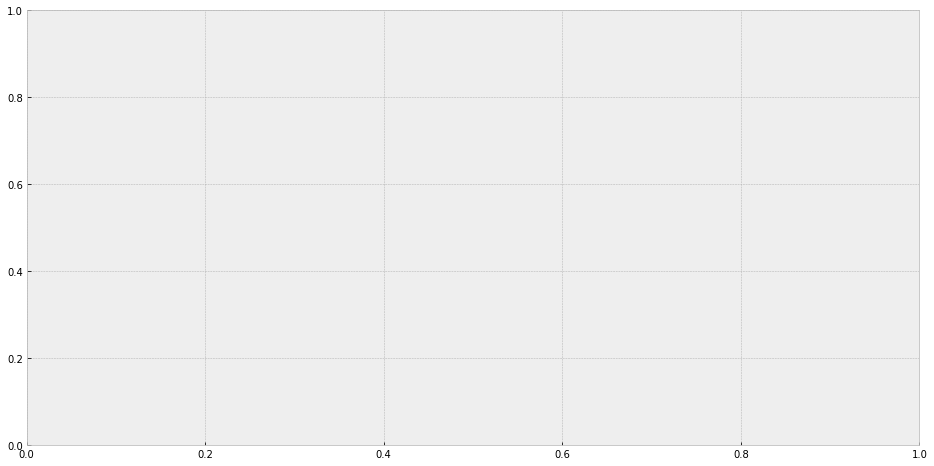

In [85]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(X_embedded.T[0], X_embedded.T[1])
ax.set_xlim(-0.105, -0.094)
ax.set_ylim(-0.075, -0.063)
fontsize=19

for i, c_name in enumerate(target_channels):
    if c_name == 'ad-cs':
        ax.annotate(c_name, (X_embedded[i][0]+0.0001, X_embedded[i][1]+0.0005), fontsize=fontsize)
    elif c_name =='support-tech':
        ax.annotate(c_name, (X_embedded[i][0]+0.0001, X_embedded[i][1]-0.0005), fontsize=fontsize)
    elif c_name =='cs-engineering':
        ax.annotate(c_name, (X_embedded[i][0]+0.0001, X_embedded[i][1]-0.0005), fontsize=fontsize)
    elif c_name =='prd-random':
        ax.annotate(c_name, (X_embedded[i][0]+0.0001, X_embedded[i][1]-0.0005), fontsize=fontsize)
    elif c_name =='ad-dev-qa':
        ax.annotate(c_name, (X_embedded[i][0]-0.001, X_embedded[i][1]+0.0005), fontsize=fontsize)
    elif c_name =='prd-team-sre':
        ax.annotate(c_name, (X_embedded[i][0]+0.0001, X_embedded[i][1]-0.0007), fontsize=fontsize)
    else:
        ax.annotate(c_name, (X_embedded[i][0]+0.0001, X_embedded[i][1]+0.0001), fontsize=fontsize)